# Internal & External Consistency

No matter where we select for path start/end, we get the same results
Results agree with Belayer aligned result
* Average trajectories with CI over length normalized gene trajectories
* Correlation coef distribution over length normalized gene trajectories

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
from scipy.stats import spearmanr
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import matplotlib.pyplot as plt
%matplotlib inline

cols = ['EPCAM', 'ACTA2', 'CD3E', 'CD27', 'CD14', 'IGKC', 'IGHA1', 'IGHG1']
normalized_length = 101

In [2]:
sys.path.append('/mnt/data1/spatial/tissue-alignment/traversal')
from io_utils import read_image, read_spatial_data

uc_path = '/mnt/data1/spatial/data/colon/UC/B'
im = read_image(uc_path, False)
pos_df, spot_radius = read_spatial_data(uc_path, False)

In [3]:
data = []
combos = []
for d in os.listdir('sampled_paths'):
    datum = pd.read_csv(f'sampled_paths/{d}/normalized_path_counts.csv', usecols=cols)[cols]
    data.append(datum.to_numpy())
    combos.append(d)
belayer = pd.read_csv('belayer_uc_normalized_path_counts.csv', usecols=cols)[cols]
data = np.asarray(data)

In [4]:
selected_idx = combos.index('241-3601') # index of path frpm fig 2

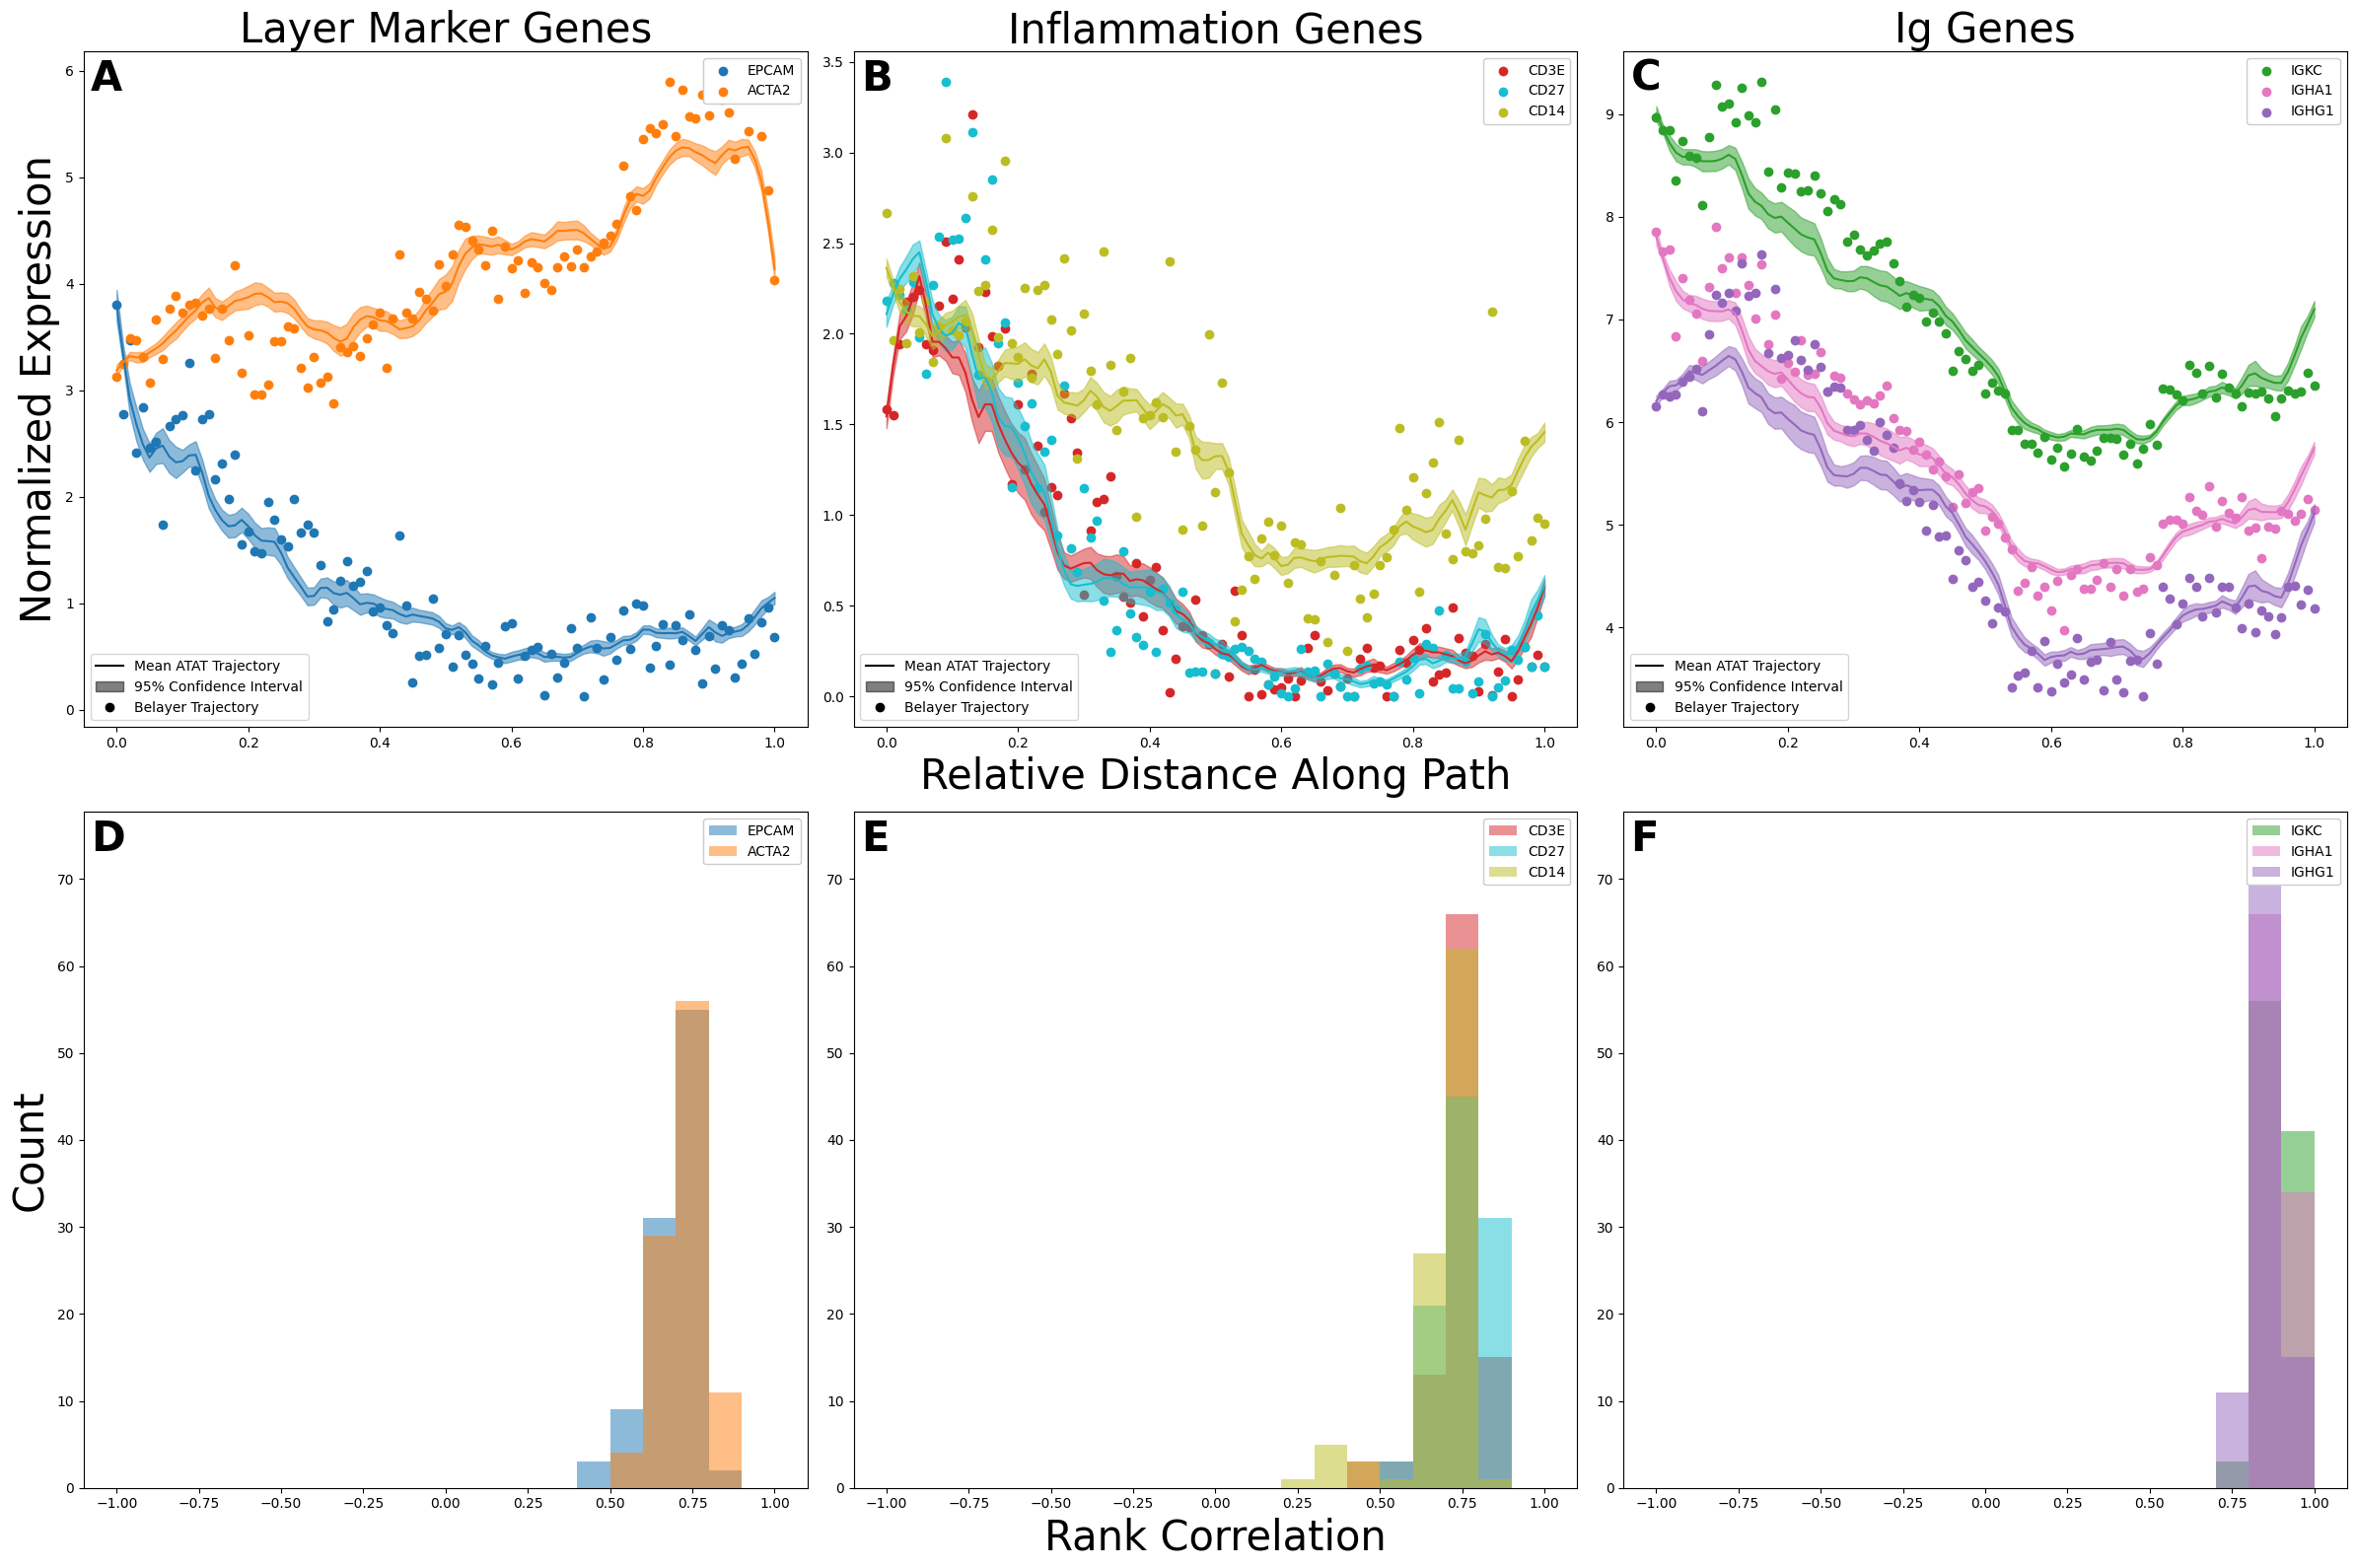

In [5]:
figsize = 8
fontsize = 15
nrows = 2
ncols = 3

plt.close()
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows, ncols, figsize=(figsize*ncols, figsize*nrows))
ax4.sharey(ax5)
ax4.sharex(ax5)
ax5.sharey(ax6)
ax5.sharex(ax6)

ax1.set_title('Layer Marker Genes', fontsize=fontsize*2)
ax2.set_title('Inflammation Genes', fontsize=fontsize*2)
ax3.set_title('Ig Genes', fontsize=fontsize*2)

ax2.set_xlabel('Relative Distance Along Path', fontsize=fontsize*2)
ax5.set_xlabel('Rank Correlation', fontsize=fontsize*2)

ax1.set_ylabel('Normalized Expression', fontsize=fontsize*2)
ax4.set_ylabel('Count', fontsize=fontsize*2)

xs = np.linspace(0, 1, normalized_length)
corr_dist_bins = np.linspace(-1, 1, 21)
num_trials = data.shape[0]

for gene, color in zip(['EPCAM', 'ACTA2'], ['tab:blue', 'tab:orange']):
    ax1.scatter(xs, belayer[gene], label=gene, color=color)
    g = cols.index(gene)
    mean = data[:,:,g].mean(axis=0)
    lower, upper = sms.DescrStatsW(data[:,:,g]).tconfint_mean()
    ax1.plot(xs, mean, color=color)
    ax1.fill_between(xs, lower, upper, color=color, alpha=0.5)

    rhos = []
    for i in range(num_trials):
        rho, p_val = spearmanr(belayer.iloc[:,g], data[i,:,g])
        rhos.append(rho)
    ax4.hist(rhos, bins=corr_dist_bins, color=color, alpha=0.5, label=gene)
    # ax4.axvline(x=rhos[selected_idx], color=color)

ax1_legend = ax1.legend(loc='upper right', framealpha=1)
ax4.legend(loc='upper right', framealpha=1)

for gene, color in zip(['CD3E', 'CD27', 'CD14'], ['tab:red', 'tab:cyan', 'tab:olive']):
    ax2.scatter(xs, belayer[gene], label=gene, color=color)
    g = cols.index(gene)
    mean = data[:,:,g].mean(axis=0)
    lower, upper = sms.DescrStatsW(data[:,:,g]).tconfint_mean()
    ax2.plot(xs, mean, color=color)
    ax2.fill_between(xs, lower, upper, color=color, alpha=0.5)

    rhos = []
    for i in range(num_trials):
        rho, p_val = spearmanr(belayer.iloc[:,g], data[i,:,g])
        rhos.append(rho)
    ax5.hist(rhos, bins=corr_dist_bins, color=color, alpha=0.5, label=gene)
    # ax5.axvline(x=rhos[selected_idx], color=color)

ax2_legend = ax2.legend(loc='upper right', framealpha=1)
ax5.legend(loc='upper right', framealpha=1)

for gene, color in zip(['IGKC', 'IGHA1', 'IGHG1'], ['tab:green', 'tab:pink', 'tab:purple']):
    ax3.scatter(xs, belayer[gene], label=gene, color=color)
    g = cols.index(gene)
    mean = data[:,:,g].mean(axis=0)
    lower, upper = sms.DescrStatsW(data[:,:,g]).tconfint_mean()
    ax3.plot(xs, mean, color=color)
    ax3.fill_between(xs, lower, upper, color=color, alpha=0.5)

    rhos = []
    for i in range(num_trials):
        rho, p_val = spearmanr(belayer.iloc[:,g], data[i,:,g])
        rhos.append(rho)
    ax6.hist(rhos, bins=corr_dist_bins, color=color, alpha=0.5, label=gene)
    # ax6.axvline(x=rhos[selected_idx], color=color)

ax3_legend = ax3.legend(loc='upper right', framealpha=1)
ax6.legend(loc='upper right', framealpha=1)

legend_elements = [
    Line2D([0], [0], color='black', label='Mean ATAT Trajectory'),
    Patch(color='black', alpha=0.5, label='95% Confidence Interval'),
    Line2D([0], [0], marker='o', ls="", color='black', label='Belayer Trajectory'),
]

ax1.legend(handles=legend_elements, loc='lower left')
ax2.legend(handles=legend_elements, loc='lower left')
ax3.legend(handles=legend_elements, loc='lower left')
ax1.add_artist(ax1_legend)
ax2.add_artist(ax2_legend)
ax3.add_artist(ax3_legend)

fig.tight_layout()

ax1_bbox = ax1.get_position()
ax2_bbox = ax2.get_position()
ax3_bbox = ax3.get_position()
ax4_bbox = ax4.get_position()
ax5_bbox = ax5.get_position()
ax6_bbox = ax6.get_position()

def _panel_label_coords(bbox, xoffset=0.01, yoffset=0.01):
    x = bbox.width * xoffset + bbox.xmin
    y = bbox.ymax - bbox.height * yoffset
    return x, y

fig.text(*_panel_label_coords(ax1_bbox), 'A', ha='left', va='top', fontsize=fontsize*2, weight='bold')
fig.text(*_panel_label_coords(ax2_bbox), 'B', ha='left', va='top', fontsize=fontsize*2, weight='bold')
fig.text(*_panel_label_coords(ax3_bbox), 'C', ha='left', va='top', fontsize=fontsize*2, weight='bold')
fig.text(*_panel_label_coords(ax4_bbox), 'D', ha='left', va='top', fontsize=fontsize*2, weight='bold')
fig.text(*_panel_label_coords(ax5_bbox), 'E', ha='left', va='top', fontsize=fontsize*2, weight='bold')
fig.text(*_panel_label_coords(ax6_bbox), 'F', ha='left', va='top', fontsize=fontsize*2, weight='bold')

fig.savefig('fig5.png')
fig.savefig('fig5.pdf')